In [ ]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from matplotlib import pyplot
from dotenv import load_dotenv
from random import randbytes
import numpy as np
import os

Section - Backend and Qubit Register Initialization

In [ ]:
load_dotenv()

provider = QiskitRuntimeService(token=os.environ["ibm_token"], channel="ibm_cloud", instance=os.environ["ibm_crn"])

# Selecting a backend
real_backend = provider.least_busy(operational=True, simulator=False)
backend = AerSimulator.from_backend(real_backend)
sampler = Sampler(backend)

num_bits = 3 # number of random bits to generate

qr = QuantumRegister(num_bits, name='qr')
cr = ClassicalRegister(num_bits, name='cr')
grover = QuantumCircuit(qr,cr)

Section - Superposition State Preparation

In [3]:
for i in range(num_bits):
    grover.h(qr[i])

Section - Oracle Definition

In [4]:
oracle = QuantumCircuit(qr, name="Oracle")
oracle.cz(0,2) # | 101>
oracle.cz(1,2) # | 011>
oracle.to_gate()

def create_diffuser(num_bits):
    """
    Creates the diffuser circuit for Grover's algorithm.

    Args:
        num_qubits: The number of qubits in the circuit.

    Returns:
        The diffuser circuit as a QuantumCircuit object.
    """
    diffuser_qr = QuantumRegister(num_bits, name="diffuser_qubits")
    diffuser_qc = QuantumCircuit(diffuser_qr, name="Diffuser")

    # Apply Hadamard gates to all qubits
    diffuser_qc.h(diffuser_qr)

    # Apply X gates to all qubits
    diffuser_qc.x(diffuser_qr)

    # Apply multi-controlled Z gate (with all qubits as controls)
    diffuser_qc.h(num_bits - 1)
    diffuser_qc.mcx(list(range(num_bits - 1)), num_bits - 1)  # Target is the last qubit
    diffuser_qc.h(num_bits - 1)

    # Apply X gates to all qubits
    diffuser_qc.x(diffuser_qr)

    # Apply Hadamard gates to all qubits
    diffuser_qc.h(diffuser_qr)

    return diffuser_qc

Section - Grover Iteration (Oracle + Diffuser)

In [5]:
diffuser = create_diffuser(num_bits)

grover.append(oracle, qr)
grover.append(diffuser, qr)

Section - Measurement

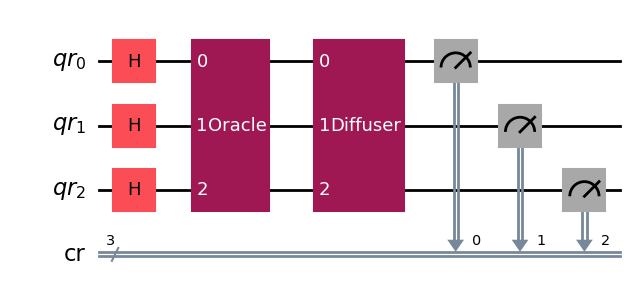

In [6]:
grover.measure(qr,cr)
grover.draw("mpl")

Section - Circuit Execution and Result Analysis

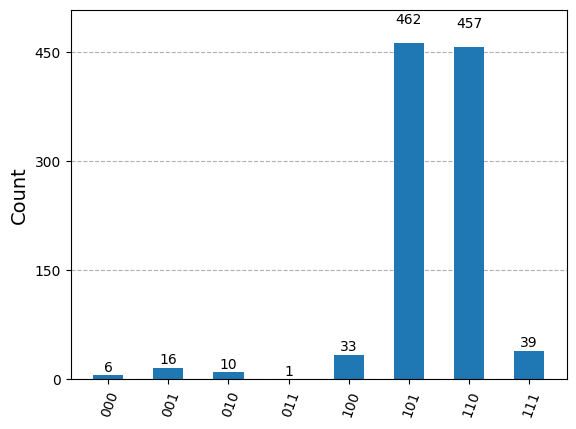

In [ ]:
qc_compiled = transpile(grover, backend)
job_sim = sampler.run([qc_compiled], shots=1024)
result_sim = job_sim.result()
counts = result_sim[0].data.cr.get_counts()

# Plot the result
plot_histogram(counts)